In [1]:
import sys
sys.path.append('../utils/')

from query import query_dataframe_f, pprint_query, nbprint_and_query
use_latex = False

# Question 2

In [2]:
q2a_data = nbprint_and_query('Q2a.sql')
q2a_data.to_csv('q2a_data.csv')

In [17]:
import pandas as pd

from trading_days import TradingDay

# Code run before this to retrieve data:
#q2a_data = nbprint_and_query('Q2a.sql')
#q2a_data.to_csv('q2a_data.csv')

q2a_data = pd.read_csv('q2a_data.csv',
                       parse_dates=['Date', 'Expiration'],
                       index_col=0)
q2a_data['AdjStrike'] = q2a_data['Strike'] / 1000.
q2a_data['ActualExpiration'] = q2a_data['Expiration'] - timedelta(days=1)

In [18]:
from datetime import datetime, timedelta
from itertools import chain
# Now, we've actually retrieved too much data.
# We first want to filter down to things that are actually +/- 10 trading days
# of an expiration. First, get all trading days, then build out all possible
# days, then filter where date is in that list of possible days.
def flatmap(f, items):
    return list(chain.from_iterable(map(f, items)))

def trading_window(date):
    return [TradingDay(n) + date
            for n in range(-11, 11)]

trading_days = flatmap(trading_window, q2a_data['ActualExpiration'].unique())

q2a_valid_data = q2a_data[q2a_data['Date'].isin(trading_days)]
q2a_valid_data.head()

,Ticker,ClosePrice,Volume,Date,Strike,OpenInterest,Expiration,AdjStrike,ActualExpiration
0,A,34.299999,2575800,2007-01-03,15000,1095454,2007-01-20,15.0,2007-01-19
1,A,34.299999,2575800,2007-01-03,17500,86720,2007-01-20,17.5,2007-01-19
2,A,34.299999,2575800,2007-01-03,20000,1033137,2007-01-20,20.0,2007-01-19
3,A,34.299999,2575800,2007-01-03,22500,75416,2007-01-20,22.5,2007-01-19
4,A,34.299999,2575800,2007-01-03,25000,3206691,2007-01-20,25.0,2007-01-19


In [19]:
# Now comes the fun part. Currently we have all strikes,
# and we essentially want to filter this down to only ATM strikes.
# Once we've accomplished that, the rest of this analysis becomes trivial
from datetime import timedelta
def find_atm_strike(df):
    # Expiration is marked as a Saturday in Ivy, so we need to do
    # df['Date'] + 1 to compensate
    prices_at_expiration = df[df['Expiration'] == df['Date'] + timedelta(days=1)]
    prices_at_expiration['Diff'] = (prices_at_expiration['AdjStrike'] -
                                    prices_at_expiration['ClosePrice']).abs()
    # And get the strike with minimum difference from close
    # We first sort ordering smallest difference first, get the first row
    # (i.e. minimum) and then its actual value
    try:
        atm_strike = (prices_at_expiration.sort_values('Diff')
                      .head(1)['AdjStrike'].values[0])
    except IndexError:
        atm_strike = 0
        
    return atm_strike
    
def filter_atm(df):
    return df[df['AdjStrike'] == find_atm_strike(df)]

q2a_groups = q2a_valid_data.groupby(['Expiration', 'Ticker'])
#q2a_atm = pd.concat([filter_atm(df) for groupname, df in q2a_groups])
q2a_atm = q2a_groups.apply(filter_atm)

C:\Users\Bradlee Speice\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
q2a_atm.to_csv('q2a_atm.csv')

In [35]:
# Now we need to build out the 'score' we will be binning on.
# The 'score' is defined as Open Interest / Avg. daily volume for
# the five days before expiration.
# The way we go about doing this is to first calculate for each row
# how many business days there are before expiration. We will re-use
# this data later in actually building the chart. Once this is done,
# we can define the score column in a vectorized form, which will make
# it much faster to calculate relative to the filtering we've done so far.
def bus_days_between(start, end):
    if start.date() == end.date():
        return 0
    elif start < end:
        return len(pd.date_range(start=start.date(),
                                 end=end.date(),
                                 closed='left',
                                 freq=TradingDay(1)))
    else:
        return -len(pd.date_range(start=end.date(),
                                  end=start.date(),
                                  closed='left',
                                  freq=TradingDay(1)))
    
q2a_atm['DeltaExpiration'] = q2a_atm.apply(
    lambda r: bus_days_between(r.Date, r.ActualExpiration),
    1)

In [36]:
q2a_atm.to_csv('q2a_atm_delta.csv')

In [59]:
def score(group):
    group['Score'] = group['OpenInterest'] / group[
        (group['DeltaExpiration'] >= 1) & (group['DeltaExpiration'] <= 5)
    ]['ClosePrice'].std()
    return group

q2a_atm_scored = q2a_atm.groupby(['Ticker', 'Expiration']).apply(score)

def did_pin(group):
    group['Pinned'] = np.abs(group['ClosePrice'] - group['AdjStrike']) < .125
    return group

q2a_atm_pinned = q2a_atm_scored.groupby(['Ticker', 'Expiration']).apply(did_pin)
q2a_atm_pinned.to_csv('q2a_atm_pinned.csv')

In [60]:
import numpy as np
bins = np.percentile(q2a_atm_scored['Score'], [25, 50, 75])

In [79]:
ppn_1 = q2a_atm_pinned[q2a_atm_scored['Score'] <= bins[0]]
ppn_2 = q2a_atm_pinned[
    (q2a_atm_pinned['Score'] > bins[0]) & (q2a_atm_pinned['Score'] < bins[1])
]
ppn_3 = q2a_atm_pinned[
    (q2a_atm_pinned['Score'] > bins[1]) & (q2a_atm_pinned['Score'] < bins[2])
]
ppn_4 = q2a_atm_pinned[q2a_atm_scored['Score'] > bins[2]]

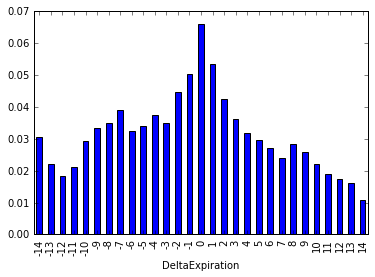

In [76]:
%matplotlib inline
ppn_1.groupby(['DeltaExpiration']).mean()['Pinned'].plot(kind='bar', by='DeltaExpiration')

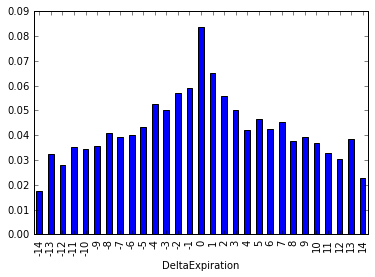

In [77]:
ppn_2.groupby(['DeltaExpiration']).mean()['Pinned'].plot(kind='bar', by='DeltaExpiration')

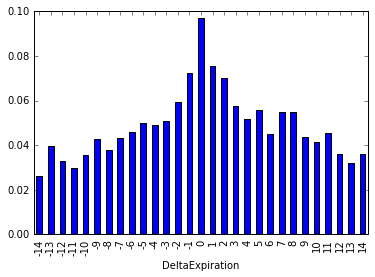

In [80]:
ppn_3.groupby(['DeltaExpiration']).mean()['Pinned'].plot(kind='bar', by='DeltaExpiration')

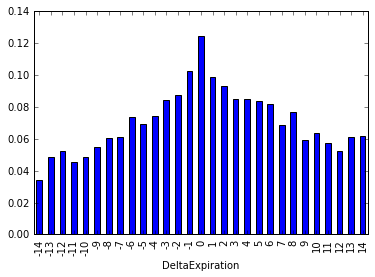

In [81]:
ppn_4.groupby(['DeltaExpiration']).mean()['Pinned'].plot(kind='bar', by='DeltaExpiration')

Finally, we need to free memory for the upcoming number crunching.

In [ ]:
del(ppn_1, ppn_2, ppn_3, ppn_4, q2a_atm_pinned, q2a_atm_scored, q2a_atm, q2a_valid_data, q2a_data)

# Problem 2b.

We now repeat the same analysis for the entire marketplace (all optionable securities).

In [ ]:
q2b_data = nbprint_and_query('Q2b.sql')
q2b_data.to_csv('q2b_data.csv')

In [ ]:
q2b_data = pd.read_csv('q2b_data.csv',
                       parse_dates=['Date', 'Expiration'],
                       index_col=0)
q2b_data['AdjStrike'] = q2b_data['Strike'] / 1000.
q2b_data['ActualExpiration'] = q2b_data['Expiration'] - timedelta(days=1)

In [ ]:
trading_days = flatmap(trading_window, q2b_data['ActualExpiration'].unique())

q2b_valid_data = q2b_data[q2b_data['Date'].isin(trading_days)]
q2b_valid_data.head()

In [ ]:
q2b_groups = q2b_valid_data.groupby(['Expiration', 'Ticker'])
q2b_atm = q2b_groups.apply(filter_atm)

In [ ]:
q2b_atm.to_csv('q2b_atm.csv')

In [ ]:
q2b_atm['DeltaExpiration'] = q2b_atm.apply(
    lambda r: bus_days_between(r.Date, r.ActualExpiration),
    1)

In [ ]:
def score(group):
    group['Score'] = group['OpenInterest'] / group[
        (group['DeltaExpiration'] >= 1) & (group['DeltaExpiration'] <= 5)
    ]['ClosePrice'].std() / group['ImpliedVolatility']
    return group

q2b_atm_scored = q2b_atm.groupby(['Ticker', 'Expiration']).apply(score)

q2b_atm_pinned = q2b_atm_scored.groupby(['Ticker', 'Expiration']).apply(did_pin)
q2b_atm_pinned.to_csv('q2b_atm_pinned.csv')

In [ ]:
import numpy as np
bins = np.percentile(q2a_atm_scored['Score'], [25, 50, 75])

In [ ]:
ppn_1 = q2a_atm_pinned[q2a_atm_scored['Score'] <= bins[0]]
ppn_2 = q2a_atm_pinned[
    (q2a_atm_pinned['Score'] > bins[0]) & (q2a_atm_pinned['Score'] < bins[1])
]
ppn_3 = q2a_atm_pinned[
    (q2a_atm_pinned['Score'] > bins[1]) & (q2a_atm_pinned['Score'] < bins[2])
]
ppn_4 = q2a_atm_pinned[q2a_atm_scored['Score'] > bins[2]]

In [ ]:
ppn_1.groupby(['DeltaExpiration']).mean()['Pinned'].plot(kind='bar', by='DeltaExpiration')

In [ ]:
ppn_2.groupby(['DeltaExpiration']).mean()['Pinned'].plot(kind='bar', by='DeltaExpiration')

In [ ]:
ppn_3.groupby(['DeltaExpiration']).mean()['Pinned'].plot(kind='bar', by='DeltaExpiration')

In [ ]:
ppn_4.groupby(['DeltaExpiration']).mean()['Pinned'].plot(kind='bar', by='DeltaExpiration')